In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile
import shutil
import numbers
from fastai.vision.image import TfmPixel
import PIL
from PIL import Image
import torch
import torchvision as vision

In [2]:
PATH = Path('/scratch/bpho_data/movies/')
movie_path = PATH/'movie_src'
test_path = PATH/'movie_test'
train_src = movie_path/'train'
valid_src = movie_path/'valid'
#Following are separated folders
TEMP_DATA = Path('/scratch/fmonroe/data/movies/')
train_hr = TEMP_DATA/'train_hr'
train_lr = TEMP_DATA/'train_lr'
train_hr_ROI = TEMP_DATA/'train_hr_ROI'
train_lr_ROI = TEMP_DATA/'train_lr_ROI'
valid_hr = TEMP_DATA/'valid_hr'
valid_lr = TEMP_DATA/'valid_lr'
valid_hr_ROI = TEMP_DATA/'valid_hr_ROI'
valid_lr_ROI = TEMP_DATA/'valid_lr_ROI'
path_models = Path('/scratch/fmonroe/models')

for folder in [train_hr, train_lr, valid_hr, valid_lr, train_hr_ROI, train_lr_ROI, valid_hr_ROI, valid_lr_ROI]:
    if folder.exists(): shutil.rmtree(folder)

In [4]:
def process_czi(czi_fn, hr_dir, lr_dir, hr_ROI_dir, lr_ROI_dir,hr_size=256):
    with czifile.CziFile(czi_fn) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C'] 
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        for channel in range(channels):
            for depth in range(depths):
                for time_col in range(times):
                    idx = build_index(proc_axes, {'T': time_col, 'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
                    img = data[idx].astype(np.float)
                    img -= img.min()
                    img /= img.max()
                    save_fn = hr_dir/f'{czi_fn.stem}_{channel:02d}_{depth:03d}_{time_col:03d}.tif'
                    pimg = PIL.Image.fromarray(img)
                    pimg.save(save_fn)
                    img = Image.open(save_fn)
                    rc = vision.transforms.RandomCrop([hr_size, hr_size])
                    sample_num = 5
                    count = 0
                        #pass in 5 sub ROIS drawn randomly from img and save them 
                        #(and its downsampled counterpart) to disk (similar to below)
                        #another for loop for samples (keep drawing ROIs and check until saving 5 samples to disk)
                        # - generate tiles (get it work first)
                        # - check tiles
                    while count < 5:
                        save_fn = hr_ROI_dir/f'{czi_fn.stem}_{channel:02d}_{depth:03d}_{time_col:03d}_{count:02d}.tif' #add sample number.
                        ROI = rc(img)
                        ROI_stats = PIL.ImageStat.Stat(ROI)
                        if ROI_stats.stddev[0]>20:
                            count = count+1
                            ROI.save(save_fn)
                            cur_size = ROI.size
                            new_size = (cur_size[0]//4, cur_size[1]//4)
                            pimg.resize(new_size, resample=PIL.Image.BICUBIC).save(lr_ROI_dir/save_fn.name)

In [5]:
if not train_hr.exists():
    for folder in [train_hr, train_lr, valid_hr, valid_lr, train_hr_ROI, train_lr_ROI, valid_hr_ROI, valid_lr_ROI]: 
        folder.mkdir(parents=True,exist_ok=True)
    train_files = list(train_src.glob('*.czi'))
    for fn in progress_bar(train_files): process_czi(fn, train_hr, train_lr, train_hr_ROI, train_lr_ROI)
    valid_files = list(valid_src.glob('*.czi'))
    for fn in progress_bar(valid_files): process_czi(fn, valid_hr, valid_lr, valid_hr_ROI, valid_lr_ROI)

In [6]:
def match_hr_func(x):
    return Path(str(x).replace('_lr','_hr'))

src = (GrayImageItemList
       .from_folder(TEMP_DATA, '*.tif', label_class=GrayImageItemList)
       .split_by_folder(train='train_lr_ROI', valid='valid_lr_ROI')
       .label_from_func(match_hr_func))

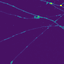

In [7]:
src.train.x[99]

In [8]:
src.train.x[0].shape

torch.Size([1, 64, 64])

In [9]:
bs = 8
sz_lr = src.train.x[0].shape[1]
sz_hr = 4*sz_lr
data = get_data(src, bs, sz_lr, sz_hr)

In [10]:
x,y  = data.train_ds[0]

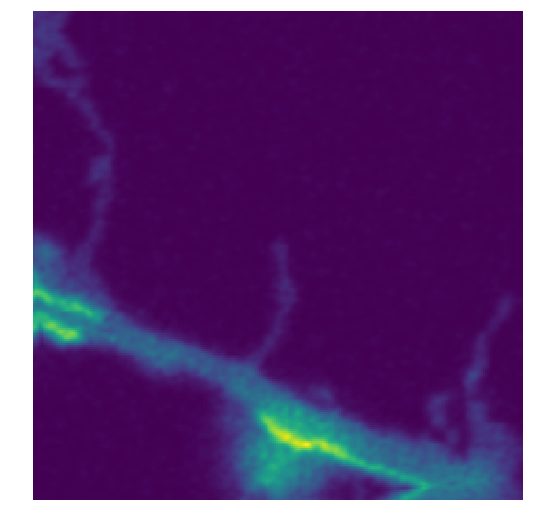

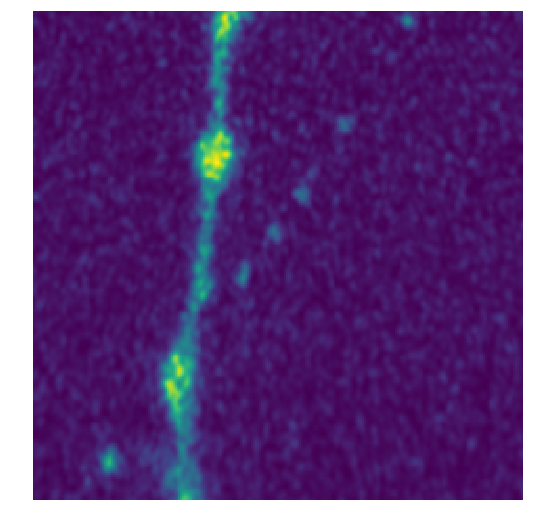

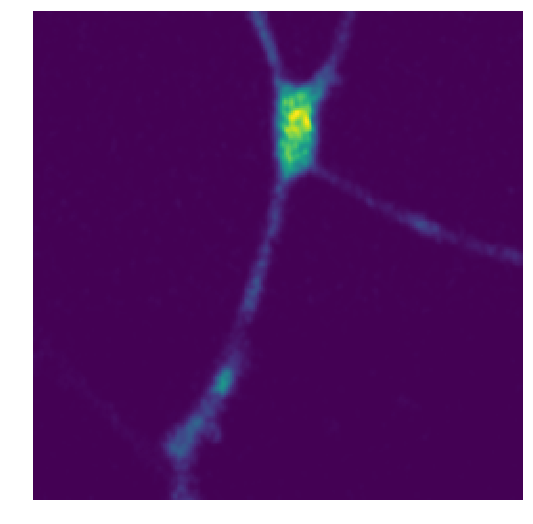

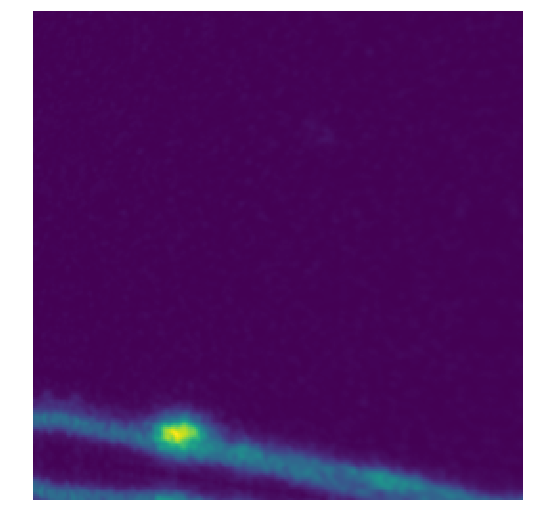

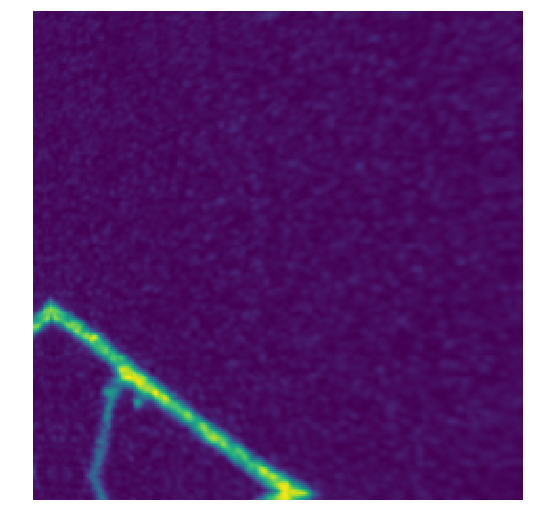

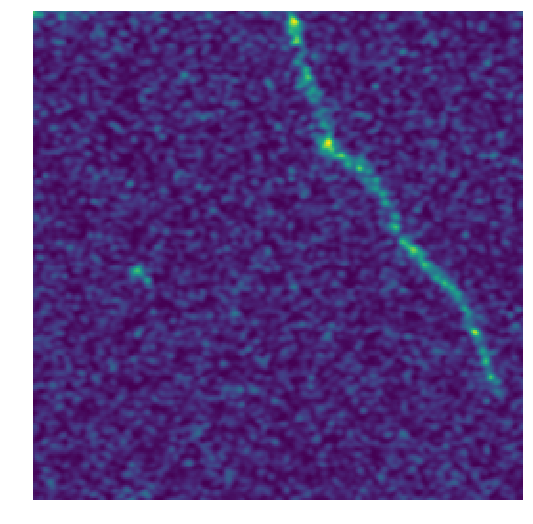

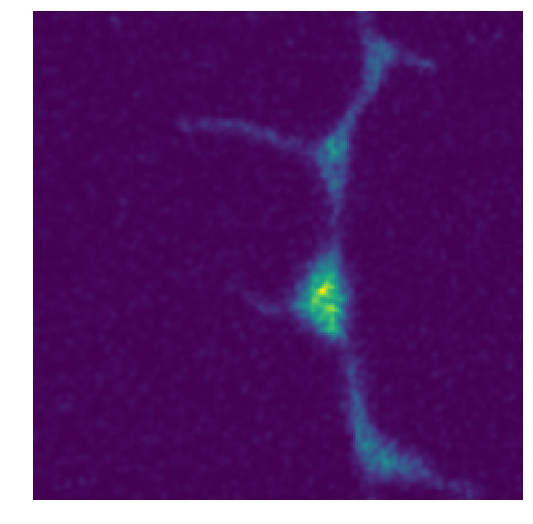

In [11]:
i = 0
for x,y in data.train_ds:
    y.show(figsize=(9,9))
    if i > 5: break
    i+=1

In [12]:
scale=4
model = DBPNLL(num_channels=1, base_filter=8, feat = 256, num_stages=10, scale_factor=scale)
model = nn.DataParallel(model, [0,1,2,3])

In [13]:
def charbonnier_loss(inputs, targets):
    eps = 1e-6;
    d = inputs - targets
    e = torch.sqrt(d**2 + eps)
    return e.mean()

loss = charbonnier_loss
#loss = F.mse_loss
#loss = F.l1_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


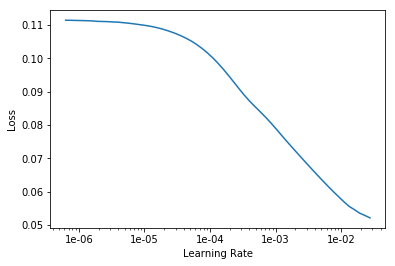

In [14]:
sz_lr = src.train.x[0].shape[1]
scale,bs = 4,16
sz_hr = sz_lr*scale

learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss, model_dir=path_models)
learn.lr_find()
learn.recorder.plot()
#learn.data.train_ds[0][0]

epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.023819,0.003417,0.000015,0.910001,48.311623
2,0.011161,0.002736,0.000007,0.939960,51.359562
3,0.006928,0.001179,0.000000,0.998300,63.567440
4,0.004579,0.001056,0.000000,0.999139,68.919365
5,0.003201,0.001018,0.000000,0.999678,73.696800
6,0.002390,0.001014,0.000000,0.999708,74.724731
7,0.001894,0.001012,0.000000,0.999730,75.341805
8,0.001584,0.001012,0.000000,0.999727,75.391182
9,0.001389,0.001011,0.000000,0.999755,75.875290
10,0.001262,0.001011,0.000000,0.999753,75.862503


save: movies_1.0


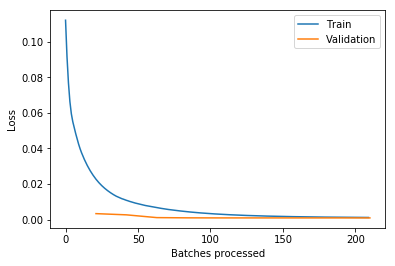

In [15]:
sz_lr = src.train.x[0].shape[1]
scale,bs = 4,16
sz_hr = sz_lr*scale
epochs, lr = 10, 1e-2
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, 
                    save='movies_1.0', 
                    loss=loss, model_dir=path_models)

In [16]:
learn.show_results(rows=2, imgsize=80)

In [17]:
lr_movies = list((test_path/'lr').iterdir())
hr_movies = list((test_path/'hr').iterdir())

In [18]:
a_movie = lr_movies[0]

In [19]:
a_movie

PosixPath('/scratch/bpho_data/movies/movie_test/lr/MitoTracker Red FM 230x230 2min 03-Airyscan Processing-03.czi')